# Causal attribution and root-cause analysis of an online shop

This notebook is an extended and updated version of the corresponding blog post: [Root Cause Analysis with DoWhy, an Open Source Python Library for Causal Machine Learning](https://aws.amazon.com/blogs/opensource/root-cause-analysis-with-dowhy-an-open-source-python-library-for-causal-machine-learning/)

In this example, we look at an online store and analyze how different factors influence our profit. In particular, we want to analyze an unexpected drop in profit and identify the potential root cause of it. For this, we can make use of Graphical Causal Models (GCM).

## The scenario

Suppose we are selling a smartphone in an online shop with a retail price of $999. The overall profit from the product depends on several factors, such as the number of sold units, operational costs or ad spending. On the other hand, the number of sold units, for instance, depends on the number of visitors on the product page, the price itself and potential ongoing promotions. Suppose we observe a steady profit of our product over the year 2021, but suddenly, there is a significant drop in profit at the beginning of 2022. Why?

In the following scenario, we will use DoWhy to get a better understanding of the causal impacts of factors influencing the profit and to identify the causes for the profit drop. To analyze our problem at hand, we first need to define our belief about the causal relationships. For this, we collect daily records of the different factors affecting profit. These factors are:

- **Shopping Event?**: A binary value indicating whether a special shopping event took place, such as Black Friday or Cyber Monday sales.
- **Ad Spend**: Spending on ad campaigns.
- **Page Views**: Number of visits on the product detail page.
- **Unit Price**: Price of the device, which could vary due to temporary discounts.
- **Sold Units**: Number of sold phones.
- **Revenue**: Daily revenue.
- **Operational Cost**: Daily operational expenses which includes production costs, spending on ads, administrative expenses, etc.
- **Profit**: Daily profit.

Looking at these attributes, we can use our domain knowledge to describe the cause-effect relationships in the form of a directed acyclic graph, which represents our causal graph in the following. The graph is shown here:

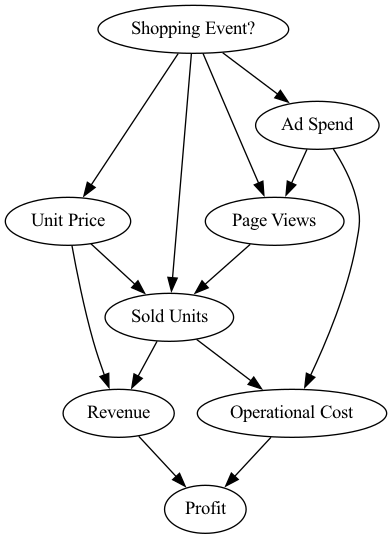

In [1]:
from IPython.display import Image
Image('online-shop-graph.png') 

In this scenario we know the following:

**Shopping Event?** impacts:  
→ Ad Spend: To promote the product on special shopping events, we require additional ad spending.  
→ Page Views: Shopping events typically attract a large number of visitors to an online retailer due to discounts and various offers.  
→ Unit Price: Typically, retailers offer some discount on the usual retail price on days with a shopping event.  
→ Sold Units: Shopping events often take place during annual celebrations like Christmas, Father’s day, etc, when people often buy more than usual.  

**Ad Spend** impacts:  
→ Page Views: The more we spend on ads, the more likely people will visit the product page.  
→ Operational Cost: Ad spending is part of the operational cost.  

**Page Views** impacts:  
→ Sold Units: The more people visiting the product page, the more likely the product is bought. This is quite obvious seeing that if no one would visit the page, there wouldn’t be any sale.  

**Unit Price** impacts:  
→ Sold Units: The higher/lower the price, the less/more units are sold.  
→ Revenue: The daily revenue typically consist of the product of the number of sold units and unit price.  

**Sold Units** impacts:  
→ Sold Units: Same argument as before, the number of sold units heavily influences the revenue.  
→ Operational Cost: There is a manufacturing cost for each unit we produce and sell. The more units we well the higher the revenue, but also the higher the manufacturing costs.  

**Operational Cost** impacts:  
→ Profit: The profit is based on the generated revenue minus the operational cost.  

**Revenue** impacts:  
→ Profit: Same reason as for the operational cost.

## Step 1: Define causal model

Now, let us model these causal relationships. In the first step, we need to define a so-called structural causal model (SCM), which is a combination of the causal graph and the underlying generative models describing the data generation process.

The causal graph can be defined via:

In [2]:
import networkx as nx

causal_graph = nx.DiGraph([('Page Views', 'Sold Units'),
                           ('Revenue', 'Profit'),
                           ('Unit Price', 'Sold Units'),
                           ('Unit Price', 'Revenue'),
                           ('Shopping Event?', 'Page Views'),
                           ('Shopping Event?', 'Sold Units'),
                           ('Shopping Event?', 'Unit Price'),
                           ('Shopping Event?', 'Ad Spend'),
                           ('Ad Spend', 'Page Views'),
                           ('Ad Spend', 'Operational Cost'),
                           ('Sold Units', 'Revenue'),
                           ('Sold Units', 'Operational Cost'),
                           ('Operational Cost', 'Profit')])

To verify that we did not forget an edge, we can plot this graph:

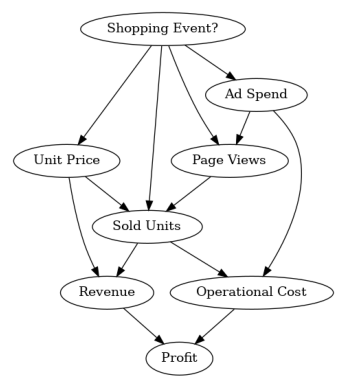

In [3]:
from dowhy.utils import plot

plot(causal_graph)

Next, we look at the data from 2021:

In [4]:
import pandas as pd
import numpy as np

pd.options.display.float_format = '${:,.2f}'.format  # Format dollar columns

data_2021 = pd.read_csv('2021 Data.csv', index_col='Date')
data_2021.head()

,Shopping Event?,Ad Spend,Page Views,Unit Price,Sold Units,Revenue,Operational Cost,Profit
Date,,,,,,,,
2021-01-01,False,"$1,490.49",11861,$999.00,2317,"$2,314,683.00","$1,659,999.89","$654,683.11"
2021-01-02,False,"$1,455.92",11776,$999.00,2355,"$2,352,645.00","$1,678,959.08","$673,685.92"
2021-01-03,False,"$1,405.82",11861,$999.00,2391,"$2,388,609.00","$1,696,906.14","$691,702.86"
2021-01-04,False,"$1,379.30",11677,$999.00,2344,"$2,341,656.00","$1,673,380.64","$668,275.36"
2021-01-05,False,"$1,234.20",11871,$999.00,2412,"$2,409,588.00","$1,707,252.61","$702,335.39"


As we see, we have one sample for each day in 2021 with all the variables in the causal graph. Note that in the synthetic data we consider here, shopping events were also generated randomly.

We defined the causal graph, but we still need to assign generative models to the nodes. We can either manually specify those models, and configure them if needed, or automatically infer “appropriate” models using heuristics from data. We will leverage the latter here:

In [5]:
from dowhy import gcm

# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph)

# Automatically assign generative models to each node based on the given data
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(scm, data_2021, override_models=True, quality=gcm.auto.AssignmentQuality.GOOD)

Whenever available, we recommend assigning models based on prior knowledge as then models would closely mimic the physics of the domain, and not rely on nuances of the data. However, here we asked DoWhy to do this for us instead.

After automatically assign the models, we can print a summary to obtain some insights into the selected models:

In [6]:
print(auto_assignment_summary)

Analyzed 8 nodes.

--- Node: Shopping Event?
Node Shopping Event? is a root node. Assigning 'Empirical Distribution' to the node representing the marginal distribution.

--- Node: Unit Price
Node Unit Price is a non-root node. Assigning 'AdditiveNoiseModel using Pipeline' to the node.
This represents the causal relationship as Unit Price := f(Shopping Event?) + N.
For the model selection, the following models were evaluated on the mean squared error (MSE) metric:
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression)]): 247.36672731822105
LinearRegression: 247.46763687596277
HistGradientBoostingRegressor: 441.70384986142096
Based on the type of causal mechanism, the model with the lowest metric value represents the best choice.

--- Node: Ad Spend
Node Ad Spend is a non-root node. Assigning 'AdditiveNoiseModel using LinearRegression' to the node.
This represents the causal relationship as Ad Spend := f(Shop

As we see, while the auto assignment also considered non-linear models, a linear model is sufficient for most relationships, except for Revenue, which is the product of Sold Units and Unit Price.

## Step 2: Fit causal models to data

After assigning a model to each node, we need to learn the parameters of the model:

In [7]:
gcm.fit(scm, data_2021)

Fitting causal models:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting causal mechanism of node Page Views:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting causal mechanism of node Sold Units:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting causal mechanism of node Revenue:   0%|          | 0/8 [00:00<?, ?it/s]   

Fitting causal mechanism of node Profit:   0%|          | 0/8 [00:00<?, ?it/s] 

Fitting causal mechanism of node Unit Price:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting causal mechanism of node Shopping Event?:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting causal mechanism of node Ad Spend:   0%|          | 0/8 [00:00<?, ?it/s]       

Fitting causal mechanism of node Operational Cost:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting causal mechanism of node Operational Cost: 100%|██████████| 8/8 [00:00<00:00, 373.84it/s]

The fit method learns the parameters of the generative models in each node. Before we continue, let's have a quick look into the performance of the causal mechanisms and how well they capture the distribution:

In [8]:
print(gcm.evaluate_causal_model(scm, data_2021, compare_mechanism_baselines=True, evaluate_invertibility_assumptions=False, evaluate_causal_structure=False))

Evaluating causal mechanisms...:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating causal mechanisms...: 100%|██████████| 8/8 [00:00<00:00, 770.94it/s]

Evaluated the performance of the causal mechanisms and the overall average KL divergence between generated and observed distribution. The results are as follows:

==== Evaluation of Causal Mechanisms ====
Root nodes are evaluated based on the KL divergence between the generated and the observed distribution.
Non-root nodes are evaluated based on the (normalized) Continuous Ranked Probability Score (CRPS), which is a generalizes the Mean Absolute Percentage Error to probabilistic predictions. Since the causal mechanisms produce conditional distributions, this should give some insights into their performance and calibration. However, note that many algorithms are still relatively robust against poor model performances.

--- Node Shopping Event?: The KL divergence between generated and observed distribution is 0.3215775274838141.
The estimated KL divergence indicates an overall very good representation of the data distribution.

--- Node Unit Price: The normalized CRPS of this node is 0.1

The fitted causal mechanisms are fairly good representations of the data generation process, with some minor inaccuracies. However, this is to be expected given the small sample size and relatively small signal-to-noise ratio for many nodes. Most importantly, all the baseline mechanisms did not perform better, which is a good indicator that our model selection is appropriate. Note that even if the models have some inaccuracies, most of the GCM-based algorithms are generally robust against this.

<div class="alert alert-block alert-info">
The selection of baseline models change be configured as well. For more details, take a look at the corresponding evaluate_causal_model documentation.
</div>

## Step 3: Answer causal questions
### What are the key factors influencing the variance in profit?

At this point, we want to understand which factors drive changes in the Profit. Let us first have a closer look at the Profit over time. For this, we plot the Profit over time for 2021, where the produced plot shows the Profit in dollars on the Y-axis and the time on the X-axis.

<Axes: xlabel='Date', ylabel='Profit in $'>

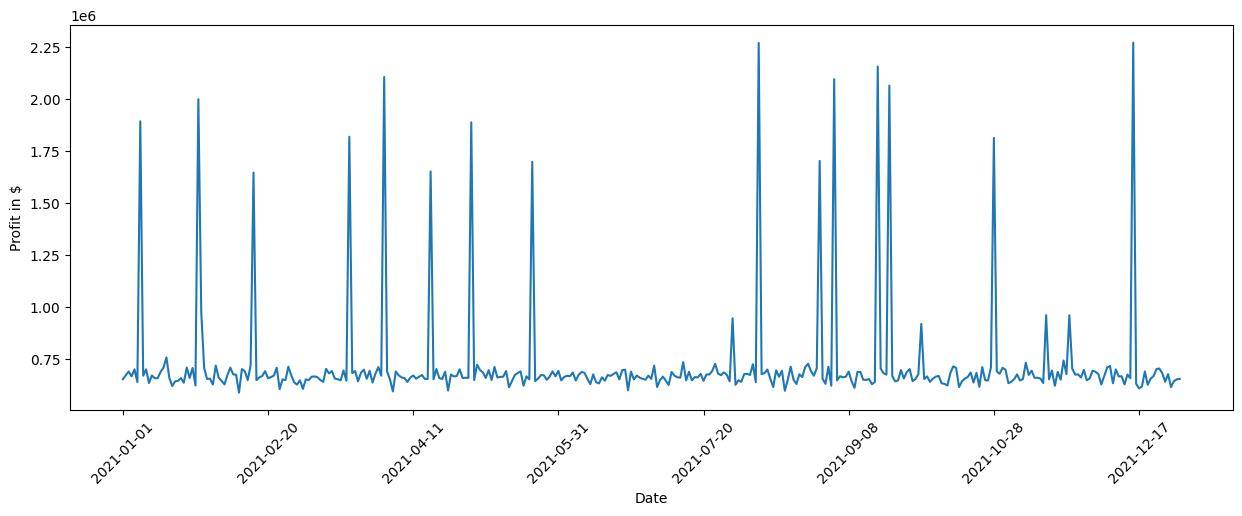

In [9]:
data_2021['Profit'].plot(ylabel='Profit in $', figsize=(15,5), rot=45)

We see some significant spikes in the Profit across the year. We can further quantify this by looking at the standard deviation:

In [10]:
data_2021['Profit'].std()

The estimated standard deviation of ~259247 dollars is quite significant. Looking at the causal graph, we see that Revenue and Operational Cost have a direct impact on the Profit, but which of them contribute the most to the variance? To find this out, we can make use of the direct arrow strength algorithm that quantifies the causal influence of a specific arrow in the graph:

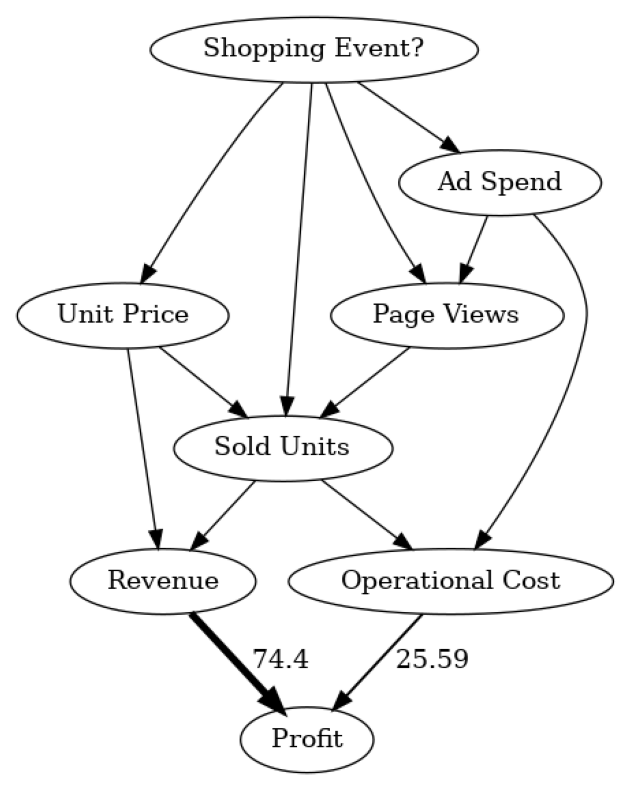

In [11]:
import numpy as np

# Note: The percentage conversion only makes sense for purely positive attributions.
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='Profit')

plot(causal_graph, 
     causal_strengths=convert_to_percentage(arrow_strengths), 
     figure_size=[15, 10])

In this causal graph, we see how much each node contributes to the variance in Profit. For simplicity, the contributions are converted to percentages. Since Profit itself is only the difference between Revenue and Operational Cost, we do not expect further factors influencing the variance. As we see, Revenue has more impact than Operational Cost. This makes sense seeing that Revenue typically varies more than Operational Cost due to the stronger dependency on the number of sold units. Note that the direct arrow strength method also supports the use of other kinds of measures, for instance, KL divergence. 

While the direct influences are helpful in understanding which direct parents influence the most on the variance in Profit, this mostly confirms our prior belief. The question of which factor is ultimately responsible for this high variance is, however, still unclear. For instance, Revenue itself is based on Sold Units and the Unit Price. Although we could recursively apply the direct arrow strength to all nodes, we would not get a correctly weighted insight into the influence of upstream nodes on the variance.

What are the important causal factors contributing to the variance in Profit? To find this out, we can use the intrinsic causal contribution method that attributes the variance in Profit to the upstream nodes in the causal graph by only considering information that is newly added by a node and not just inherited from its parents. For instance, a node that is simply a rescaled version of its parent would not have any intrinsic contribution. See the corresponding [research paper](https://arxiv.org/abs/2007.00714) for more details.

Let's apply the method to the data:

In [12]:
iccs = gcm.intrinsic_causal_influence(scm, target_node='Profit', num_samples_randomization=500)

  0%|          | 0/1 [00:00<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 2 (10 evaluated permutations): 5.700412776356154%:   0%|          | 0/1 [00:11<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 3 (15 evaluated permutations): 6.334686878455788%:   0%|          | 0/1 [00:15<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): 2.771431925721596%:   0%|          | 0/1 [00:19<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 5 (25 evaluated permutations): 2.013650590697222%:   0%|          | 0/1 [00:23<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 6 (30 evaluated permutations): 2.340894796328266%:   0%|          | 0/1 [00:26<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 7 (35 evaluated permutations): 2.4957760460921032%:   0%|          | 0/1 [00:28<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 8 (40 evaluated permutations): 1.1018664620010388%:   0%|          | 0/1 [00:31<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 9 (45 evaluated permutations): 1.1108306843001556%:   0%|          | 0/1 [00:34<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): 1.2186514845827736%:   0%|          | 0/1 [00:35<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): 1.2186514845827736%: 100%|██████████| 1/1 [00:35<00:00, 35.60s/it]

Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): 1.2186514845827736%: 100%|██████████| 1/1 [00:35<00:00, 35.60s/it]

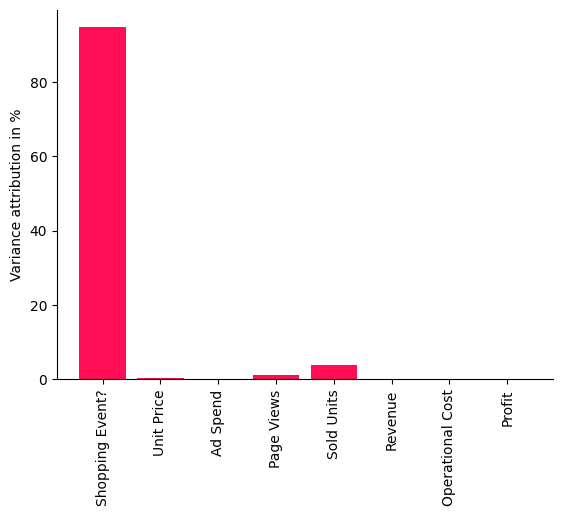

In [13]:
from dowhy.utils import bar_plot

bar_plot(convert_to_percentage(iccs), ylabel='Variance attribution in %')

The scores shown in this bar chart are percentages indicating how much variance each node is contributing to Profit — without inheriting the variance from its parents in the causal graph. As we see quite clearly, the Shopping Event has by far the biggest influence on the variance in our Profit. This makes sense, seeing that the sales are heavily impacted during promotion periods like Black Friday or Prime Day and, thus, impact the overall profit. Surprisingly, we also see that factors such as the number of sold units or number of page views have a rather small influence, i.e., the large variance in profit can be almost completely explained by the shopping events. Let’s check this visually by marking the days where we had a shopping event. To do so, we use the pandas plot function again, but additionally mark all points in the plot with a vertical red bar where a shopping event occured:

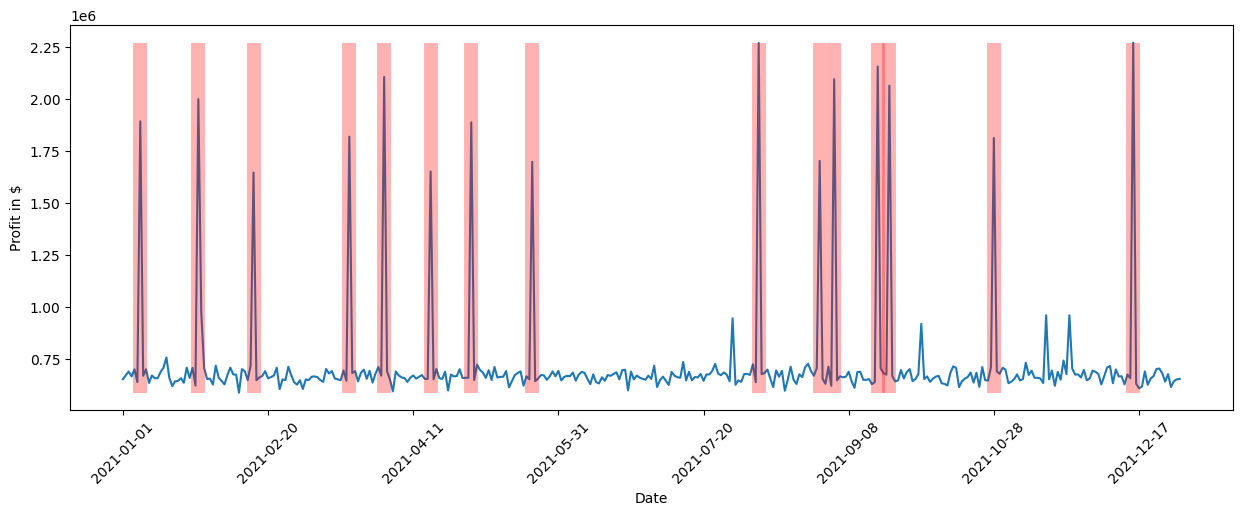

In [14]:
import matplotlib.pyplot as plt

data_2021['Profit'].plot(ylabel='Profit in $', figsize=(15,5), rot=45)
plt.vlines(np.arange(0, data_2021.shape[0])[data_2021['Shopping Event?']], data_2021['Profit'].min(), data_2021['Profit'].max(), linewidth=10, alpha=0.3, color='r')

We clearly see that the shopping events coincide with the high peaks in profit. While we could have investigated this manually by looking at all kinds of different relationships or using domain knowledge, the tasks gets much more difficult as the complexity of the system increases. With a few lines of code, we obtained these insights from DoWhy.

### What are the key factors explaining the Profit drop on a particular day?

After a successful year in terms of profit, newer technologies come to the market and, thus, we want to keep the profit up and get rid of excess inventory by selling more devices. In order to increase the demand, we therefore lower the retail price by 10% at the beginning of 2022. Based on a prior analysis, we know that a decrease of 10% in the price would roughly increase the demand by 13.75%, a slight surplus. Following the price elasticity of demand model, we expect an increase of around 37.5% in number of Sold Units. Let us take a look if this is true by loading the data for the first day in 2022 and taking the fraction between the numbers of Sold Units from both years for that day:

In [15]:
first_day_2022 = pd.read_csv('2022 First Day.csv', index_col='Date')
(first_day_2022['Sold Units'][0] / data_2021['Sold Units'][0] - 1) * 100

Surprisingly, we only increased the number of sold units by ~19%. This will certainly impact the profit given that the revenue is much smaller than expected. Let us compare it with the previous year at the same time:

In [16]:
(1 - first_day_2022['Profit'][0] / data_2021['Profit'][0]) * 100

Indeed, the profit dropped by ~8.5%. Why is this the case seeing that we would expect a much higher demand due to the decreased price? Let us investigate what is going on here.

In order to figure out what contributed to the Profit drop, we can make use of DoWhy’s anomaly attribution feature. Here, we only need to specify the target node we are interested in (the Profit) and the anomaly sample we want to analyze (the first day of 2022). These results are then plotted in a bar chart indicating the attribution scores of each node for the given anomaly sample:

  0%|          | 0/1 [00:00<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 2 (10 evaluated permutations): 62.688202333018026%:   0%|          | 0/1 [00:00<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 3 (15 evaluated permutations): 15.763193728684291%:   0%|          | 0/1 [00:00<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): 15.843668998431095%:   0%|          | 0/1 [00:01<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 5 (25 evaluated permutations): 14.781006920804792%:   0%|          | 0/1 [00:01<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 6 (30 evaluated permutations): 10.18179673370484%:   0%|          | 0/1 [00:01<?, ?it/s] 

Estimating Shapley Values. Average change of Shapley values in run 7 (35 evaluated permutations): 12.70633457010651%:   0%|          | 0/1 [00:01<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 8 (40 evaluated permutations): 7.1895795474097195%:   0%|          | 0/1 [00:01<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 9 (45 evaluated permutations): 14.250096524814964%:   0%|          | 0/1 [00:01<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): 8.278803922989818%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 11 (55 evaluated permutations): 5.331477864986306%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 12 (60 evaluated permutations): 9.176633421800059%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 13 (65 evaluated permutations): 3.933005279811082%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 14 (70 evaluated permutations): 4.950729646625351%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 15 (75 evaluated permutations): 3.7709041954357145%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 16 (80 evaluated permutations): 5.913992590115846%:   0%|          | 0/1 [00:02<?, ?it/s] 

Estimating Shapley Values. Average change of Shapley values in run 17 (85 evaluated permutations): 3.160262463138612%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 18 (90 evaluated permutations): 14.467673211724378%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 19 (95 evaluated permutations): 4.497421972019465%:   0%|          | 0/1 [00:02<?, ?it/s] 

Estimating Shapley Values. Average change of Shapley values in run 20 (100 evaluated permutations): 7.756514678315014%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 21 (105 evaluated permutations): 2.9239694137542807%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 22 (110 evaluated permutations): 3.42549220937579%:   0%|          | 0/1 [00:02<?, ?it/s]  

Estimating Shapley Values. Average change of Shapley values in run 23 (115 evaluated permutations): 1.8563067156496555%:   0%|          | 0/1 [00:02<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 24 (120 evaluated permutations): 4.163051708592666%:   0%|          | 0/1 [00:03<?, ?it/s] 

Estimating Shapley Values. Average change of Shapley values in run 25 (125 evaluated permutations): 2.2351536257965057%:   0%|          | 0/1 [00:03<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 26 (130 evaluated permutations): 2.59136410710724%:   0%|          | 0/1 [00:03<?, ?it/s]  

Estimating Shapley Values. Average change of Shapley values in run 27 (135 evaluated permutations): 3.57840735555702%:   0%|          | 0/1 [00:03<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 28 (140 evaluated permutations): 2.6221783577748528%:   0%|          | 0/1 [00:03<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 29 (145 evaluated permutations): 3.411637391635368%:   0%|          | 0/1 [00:03<?, ?it/s] 

Estimating Shapley Values. Average change of Shapley values in run 30 (150 evaluated permutations): 2.391115010693702%:   0%|          | 0/1 [00:03<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 31 (155 evaluated permutations): 2.3435092094920895%:   0%|          | 0/1 [00:03<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 32 (160 evaluated permutations): 2.4703277278427027%:   0%|          | 0/1 [00:03<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 33 (165 evaluated permutations): 1.857088572777503%:   0%|          | 0/1 [00:03<?, ?it/s] 

Estimating Shapley Values. Average change of Shapley values in run 34 (170 evaluated permutations): 1.6749969587997127%:   0%|          | 0/1 [00:03<?, ?it/s]

Estimating Shapley Values. Average change of Shapley values in run 34 (170 evaluated permutations): 1.6749969587997127%: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]

Estimating Shapley Values. Average change of Shapley values in run 34 (170 evaluated permutations): 1.6749969587997127%: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]

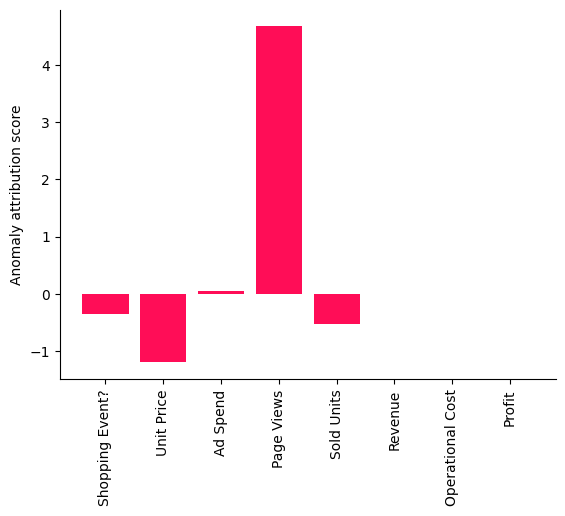

In [17]:
attributions = gcm.attribute_anomalies(scm, target_node='Profit', anomaly_samples=first_day_2022)

bar_plot({k: v[0] for k, v in attributions.items()}, ylabel='Anomaly attribution score')

A positive attribution score means that the corresponding node contributed to the observed anomaly, which is in our case the drop in Profit. A negative score of a node indicates that the observed value for the node is actually reducing the likelihood of the anomaly (e.g., a higher demand due to the decreased price should increase the profit). More details about the interpretation of the score can be found in the corresponding [reserach paper](https://proceedings.mlr.press/v162/budhathoki22a.html). Interestingly, the Page Views stand out as a factor explaining the Profit drop that day as indicated in the bar chart shown here.

While this method gives us a point estimate of the attributions for the particular models and parameters we learned, we can also use DoWhy’s confidence interval feature, which incorporates uncertainties about the fitted model parameters and algorithmic approximations:

In [18]:
gcm.config.disable_progress_bars()  # We turn off the progress bars here to reduce the number of outputs.

median_attributions, confidence_intervals, = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.attribute_anomalies,
                        scm,
                        bootstrap_training_data=data_2021,
                        target_node='Profit',
                        anomaly_samples=first_day_2022),
    num_bootstrap_resamples=10)

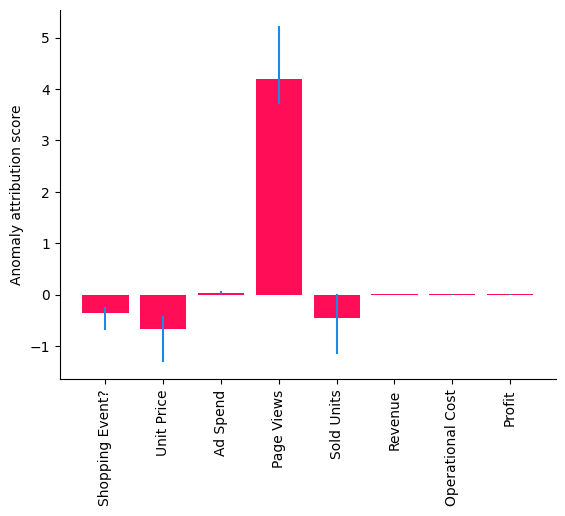

In [19]:
bar_plot(median_attributions, confidence_intervals, 'Anomaly attribution score')

Note, in this bar chart we see the median attributions over multiple runs on smaller data sets, where each run re-fits the models and re-evaluates the attributions. We get a similar picture as before, but the confidence interval of the attribution to Sold Units also contains zero, meaning its contribution is insignificant. But some important questions still remain: Was this only a coincidence and, if not, which part in our system has changed? To find this out, we need to collect some more data.

<div class="alert alert-block alert-info">
Note that the results differ depending on the selected data, since they are sample specific. On other days, other factors could be relevant. Furthermore, note that the analysis (including the confidence intervals) always relies on the modeling assumptions made. In other words, if the models change or have a poor fit, one would also expect different results.
</div>

### What caused the profit drop in Q1 2022?

While the previous analysis is based on a single observation, let us see if this was just coincidence or if this is a persistent issue. When preparing the quarterly business report, we have some more data available from the first three months. We first check if the profit dropped on average in the first quarter of 2022 as compared to 2021. Similar as before, we can do this by taking the fraction between the average Profit of 2022 and 2021 for the first quarter:

In [20]:
data_first_quarter_2021 = data_2021[data_2021.index <= '2021-03-31']
data_first_quarter_2022 = pd.read_csv("2022 First Quarter.csv", index_col='Date')

(1 - data_first_quarter_2022['Profit'].mean() / data_first_quarter_2021['Profit'].mean()) * 100

Indeed, the profit drop is persistent in the first quarter of 2022. Now, what is the root cause of this? Let us apply the [distribution change method](https://proceedings.mlr.press/v130/budhathoki21a.html) to identify the part in the system that has changed:

In [21]:
median_attributions, confidence_intervals = gcm.confidence_intervals(
    lambda: gcm.distribution_change(scm,
                                    data_first_quarter_2021,
                                    data_first_quarter_2022,
                                    target_node='Profit',
                                    # Here, we are intersted in explaining the differences in the mean.
                                    difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x)) 
)

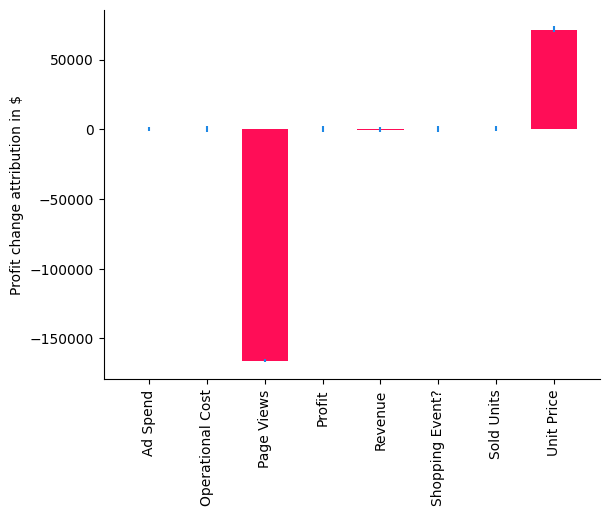

In [22]:
bar_plot(median_attributions, confidence_intervals, 'Profit change attribution in $')

In our case, the distribution change method explains the change in the mean of Profit, i.e., a negative value indicates that a node contributes to a decrease and a positive value to an increase of the mean. Using the bar chart, we get now a very clear picture that the change in Unit Price has actually a slightly positive contribution to the expected Profit due to the increase of Sold Units, but it seems that the issue is coming from the Page Views which has a negative value. While we already understood this as a main driver of the drop at the beginning of 2022, we have now isolated and confirmed that something changed for the Page Views as well. Let’s compare the average Page Views with the previous year.

In [23]:
(1 - data_first_quarter_2022['Page Views'].mean() / data_first_quarter_2021['Page Views'].mean()) * 100

Indeed, the number of Page Views dropped by ~14%. Since we eliminated all other potential factors, we can now dive deeper into the Page Views and see what is going on there. This is a hypothetical scenario, but we could imagine it could be due to a change in the search algorithm which ranks this product lower in the results and therefore drives fewer customers to the product page. Knowing this, we could now start mitigating the issue.

# Data generation process

While the exact same data cannot be reproduced, the following dataset generator should provide quite similar types of data and has various parameters to adjust:

In [24]:
from dowhy.datasets import sales_dataset

data_2021 = sales_dataset(start_date="2021-01-01", end_date="2021-12-31")
data_2022 = sales_dataset(start_date="2022-01-01", end_date="2022-12-31", change_of_price=0.9)